In [1]:
import matplotlib.pyplot as pp
import pandas as pd
import numpy as np
import os
import sys
sys.path.append('/Users/datnguyen/Work/others/')

from utils.db_utils import df_from_snowflake
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from utils.curve_fitting import *

platforms=['android', 'ios']

In [3]:
query = """
select
        date_trunc('day', date) dt,
        os_name platform,
        iff(os_name='ios', 'id' || app_id, app_id) app_id,
        media_source,
        count(distinct iff(event_name = 'install', appsflyer_id, null))+sum(iff(event_name = 'af_skad_install', 1, 0)) total_installs,
        count(distinct iff(event_name = 'install', appsflyer_id, null)) regular_installs,
        sum(iff(event_name = 'af_skad_install', 1, 0)) skad_installs,
        count(distinct iff(event_name = 'retargeting', appsflyer_id, null)) retargeting,
        count(distinct iff(event_name = 'uninstall', appsflyer_id, null)) uninstalls,
        0 as cost
    from stage.reporting_marketing.appsflyer_installs_uninstalls
    where true 
    and date between '2023-07-01' and '2023-10-15'
    and app_id in (
        'com.hometogo',
        '1104996296'
    )
    group by 1,2,3,4
    order by 1,2,3,4
"""

In [4]:
data = df_from_snowflake(query)

In [5]:
data.DT=pd.to_datetime(data.DT)
data['is_paid']=data.MEDIA_SOURCE.isin(['Facebook Ads', 'googleadwords_int', 'Apple Search Ads'])

paid_installs=data.loc[data.is_paid].groupby(['DT', 'PLATFORM']).sum()['TOTAL_INSTALLS'].unstack().resample('1D').sum()
organic_installs=data.loc[data.MEDIA_SOURCE=='organic'].groupby(['DT', 'PLATFORM']).sum()['TOTAL_INSTALLS'].unstack().resample('1D').sum()

corr_result = pd.DataFrame(index=platforms, columns=['correlation_coefficient: r'])
for platform in platforms:
    corr = np.corrcoef([paid_installs[platform].astype(float), 
                        organic_installs[platform].astype(float)]
    ).min()
    corr_result.loc[platform] = corr
print(corr_result)

        correlation_coefficient: r
android                   0.704359
ios                       0.746022


## Hold-Out

In [6]:
X_train, X_test, y_train, y_test = train_test_split(paid_installs,
                                                    organic_installs,
                                                    test_size=0.15,
                                                    random_state=42
                                                    )

In [11]:
def mean(x, y):
    return sum(x*y) / sum(y)

def sigma (x, y):
    return np.sqrt(sum(y * (x - mean(x, y))**2) / sum(y))

def fit_and_plot(f, parameters:list, p0=None, maxfev=1000, get_ci:bool=False):
    results_df = pd.DataFrame(index=platforms, columns=[parameters + ['R2', 'RMSE']])
    results_95ci = pd.DataFrame(index=platforms, columns=[coef + "_95ci" for coef in parameters])

    _, ax = pp.subplots(nrows=len(platforms), ncols=3, sharex='col', figsize=(12, 8))
    for n, platform in enumerate(platforms):
        ax[n,0].plot(X_train[platform].sort_index(), color='blue', label='paid')
        ax[n,0].plot(y_train[platform].sort_index(), color='red', label='organic')
        ax[n,0].set(title=platform)
        ax[n,0].legend()
        ax[n,0].tick_params(axis='x', labelrotation=90)
        ax[n,0].set_ylabel('installs')

        ## Fit 
        X = np.array(X_train[platform].sort_index(), dtype=float)
        y = np.array(y_train[platform].sort_index(), dtype=float)
        
        if f.__name__=='gauss': p0=[1, mean(X, y), sigma(X, y)]
        elif f.__name__=='sigmoid': p0=[max(y), np.median(X), 0.1, min(y)]

        popt, pcov = curve_fit(
            f, 
            X, 
            y,
            p0=p0,
            maxfev=maxfev
        )
        x_ = np.linspace(X.min(), X.max())
        organic_predicted = f(x_, *popt)
        
        std = np.sqrt(np.diagonal(pcov))                                #standard deviation of errors on parameters
        lower_popt = popt - 1.96*std                                    #95% CI ~ 1.96std
        upper_popt = popt + 1.96*std

        lower_bound = f(x_, *(lower_popt))
        upper_bound = f(x_, *(upper_popt))

        ## plot data points
        ax[n,1].scatter(x=X, y=y, color='gray', alpha=0.4, label='train')                               #train data points
        ax[n,1].scatter(x=X_test[platform], y=y_test[platform], color='red',alpha=0.4, label='test')    #test data points
        ## plot regression line
        ax[n,1].plot(x_, organic_predicted, linestyle='--', label='reg line')
        if get_ci:
            ax[n,1].fill_between(x_,
                                lower_bound,
                                upper_bound,
                                color='blue',
                                alpha=0.15
            )
        ax[n,1].set(title=platform)
        ax[n,1].set_xlabel('paid')
        ax[n,1].set_ylabel('organic')
        ax[n,1].legend()

        ax[n,2].set(title=platform)
        ax[n,2].errorbar(X,
                         y - f(X, *popt),
                         fmt='b.',
                         label='residuals'
        )
        ax[n,2].set_ylim(-max(y),max(y))
        ax[n,2].hlines(0, 0, max(X))
        ax[n,2].legend()

        results_df.loc[platform, parameters] = popt
        results_df.loc[platform, 'R2'] = r2_score(np.array(y_test[platform], dtype=float), 
                                                  f(np.array(X_test[platform], dtype=float), *popt)
                                                    )
        results_df.loc[platform, 'RMSE'] = mean_squared_error(np.array(y_test[platform], dtype=float), 
                                                             f(np.array(X_test[platform], dtype=float), *popt),
                                                             squared=False
                                                            )
        
        for i, coef in enumerate(parameters):
            results_95ci.loc[platform,[coef + "_95ci"]] = str(round(lower_popt[i],1)) + ", " + str(round(upper_popt[i],1))

    print(results_df, '\n')
    if get_ci: print(results_95ci)
    #print(pcov)

## Linear Function

           Intercept Coefficient        R2        RMSE
android   652.091673    1.276629  0.680795  312.424681
ios      1228.774188    1.769991  0.520827  761.988105 

        Intercept_95ci Coefficient_95ci
android   357.8, 946.4         1.0, 1.6
ios      803.8, 1653.8         1.4, 2.1

      r: correlation coefficient saying how strong is the relation between X and y
      R2: coefficient of determination saying how much variability of y can be explained by X
      in simple linear regression, r2 = R2
      


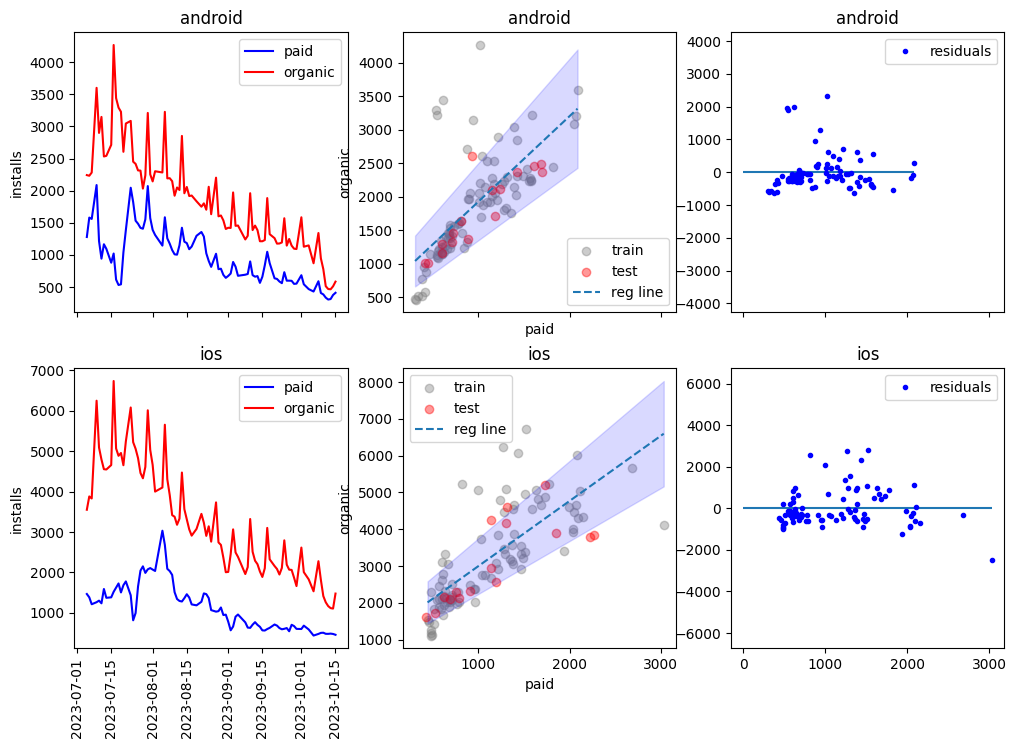

In [12]:
fit_and_plot(linear, parameters=['Intercept', 'Coefficient'], p0=[0,0], get_ci=True)
print("""
      r: correlation coefficient saying how strong is the relation between X and y
      R2: coefficient of determination saying how much variability of y can be explained by X
      in simple linear regression, r2 = R2
      """)

## Gaussian Function

                   a            b        sigma        R2        RMSE
android  2964.287063  2155.954758  1275.839197  0.683967  310.868427
ios      4942.449585  2188.244385  1223.958366  0.646337  654.631617 



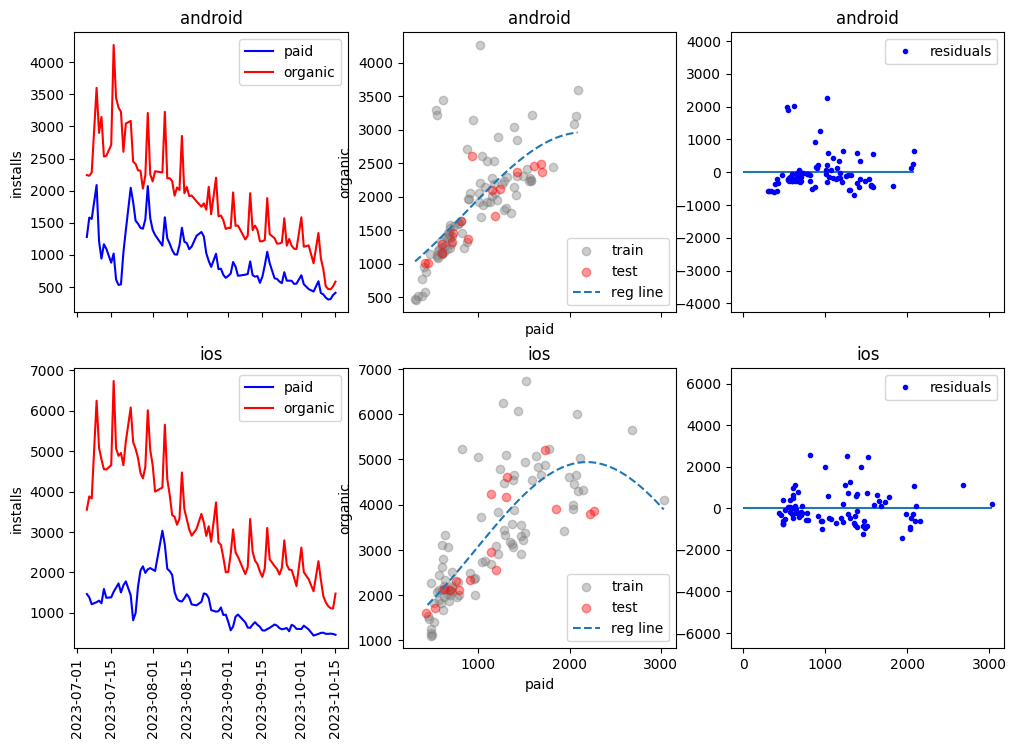

In [15]:
fit_and_plot(gauss, parameters=['a', 'b', 'sigma'], get_ci=False)

## Diminishing Return

                   a          b         c         d        R2        RMSE
android   -1965.8943  21.159278   0.02703  1.017532  0.703448    301.1351
ios     -3914.318847  27.869713  0.027814  1.013065  0.613537  684.314707 



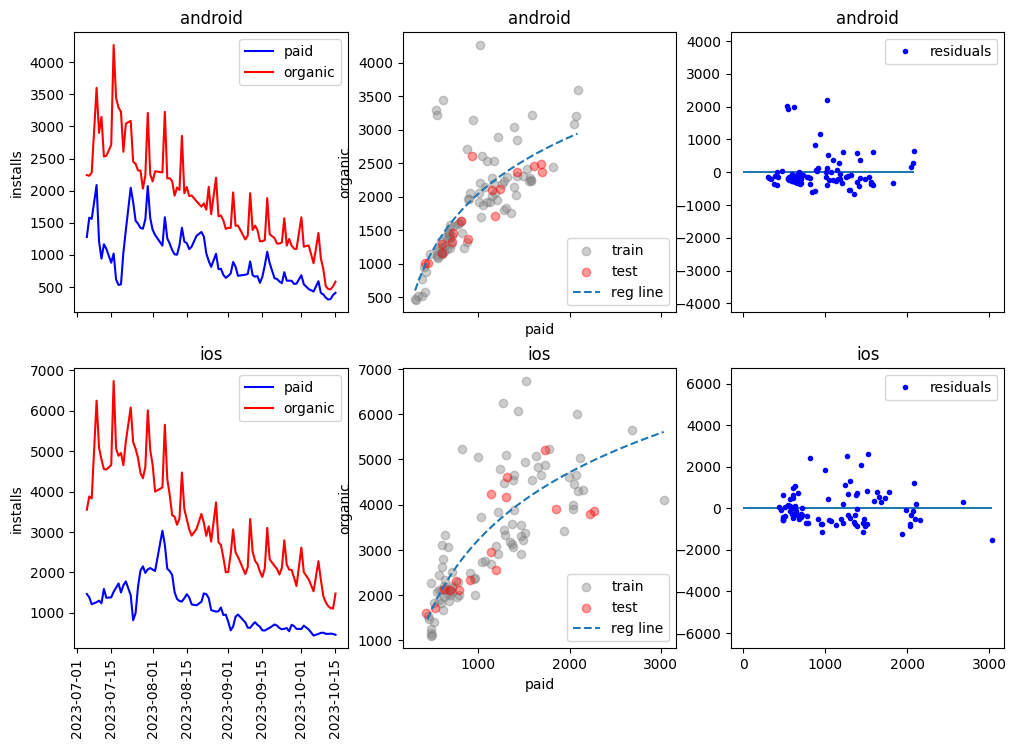

In [13]:
fit_and_plot(logarithm, parameters=['a', 'b', 'c', 'd'], p0=[1, 1, 1, 5], maxfev=1000, get_ci=False)

                a         b           c        R2        RMSE
android -0.000494  2.357168  157.686107  0.700921  302.415089
ios     -0.000967  4.434117 -241.742934  0.660084   641.78276 



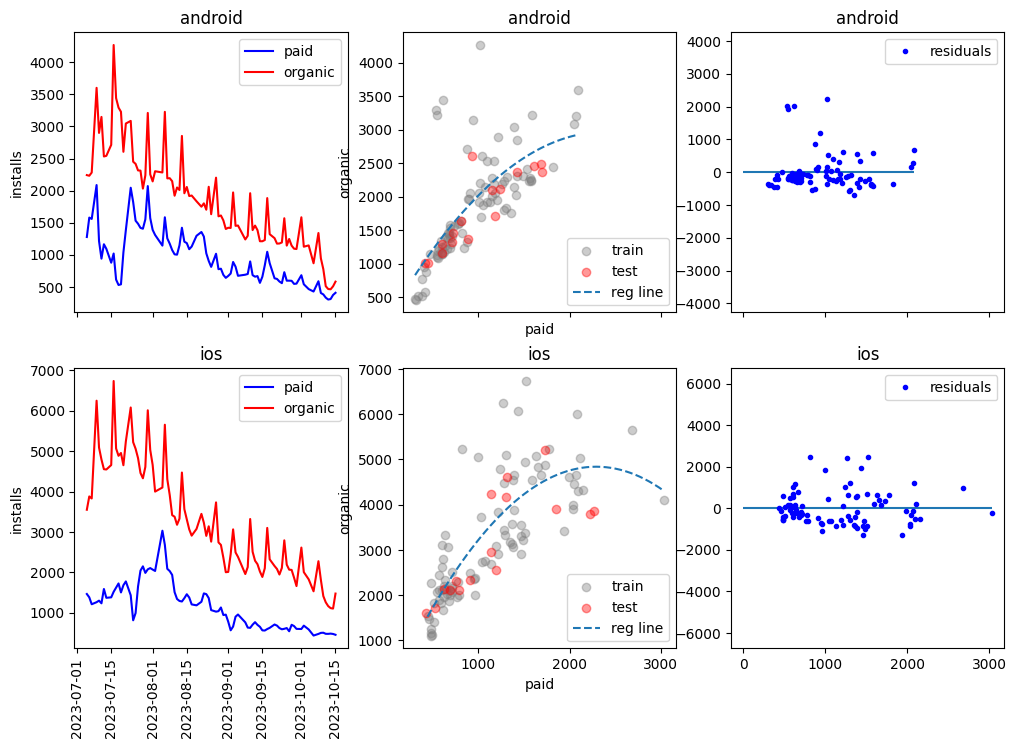

In [14]:
fit_and_plot(polynomial, parameters=['a', 'b', 'c'], p0=[-0.1, 1, 1], maxfev=1000, get_ci=False)

## Sigmoid Function

In [ ]:
fit_and_plot(sigmoid, parameters=['A', 'x0', 'k', 'offset'], maxfev=1000)